In [1]:
import nibabel as nib
from nibabel import processing as prc
import numpy as np
import scipy.stats as stats
import os

In [ ]:
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

In [ ]:
for n, sub in enumerate(sublist):
    sub = sub.strip()
    aparc = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/aparc+aseg.nii.gz' %sub)
    aparc_data = aparc.get_fdata()
    affine = aparc.affine
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        maskname = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA_finalmask.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        maskname = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA_finalmask.nii.gz' %sub)
    epi_mask = nib.load(maskname)

#Generate mask and resample to MNI152 2mm space (to match epi time series)
    gm_mask = np.zeros_like(aparc_data)
    for x in range(0,gm_mask.shape[0]-1): #Loop method
        for y in range(0,gm_mask.shape[1]-1):
            for z in range(0,gm_mask.shape[2]-1):
                if aparc_data[x,y,z] >= 1000:
                    gm_mask[x,y,z] = 1
    
    gm_mask_nifti = nib.Nifti1Image(gm_mask,affine)

    resampled_gm_mask = prc.resample_from_to(gm_mask_nifti,epi_mask,order=0)
   
    nib.save(resampled_gm_mask,'/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_gm_mask.nii.gz' %sub)


#EPI can now be multiplied with resampled gm_mask and averaged using FSL (extracting average global gm signal in each volume)

#Run fslmaths resampled_gm_mask.nii.gz -mul MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz gm_signal.nii.gz
#Output is gm_signal.nii.gz

In [59]:
v1_gm_correlations = []
v2_gm_correlations = []
v4_gm_correlations = []
p1s = []
p2s = []
p4s = []
sub_with_sig_corr4 = []
swsc1 = []
swsc2 = []
cerebellar_mask = nib.load('/usr/local/fsl/data/atlases/Cerebellum/Cerebellum-MNIflirt-maxprob-thr0-2mm.nii.gz')
for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    wm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_wm_mask.nii.gz' %sub)
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent4_sphere = epi_data[44:45,44:45,34:36,:] #4th ventricle
    vent1_sphere = epi_data[33:39,41:47,42:48,:] #Primary ventricle (along CC, posterior)
    vent2_sphere = epi_data[40:46,65:71,39:45,:] #Primary ventricle (along CC, anterior)
    avg_vent4 = []
    avg_vent1 = []
    avg_vent2 = []
    for t in range(0,vent4_sphere.shape[3]):    
        v4_avg = np.mean(vent4_sphere[:,:,:,t])
        v1_avg = np.mean(vent1_sphere[:,:,:,t])
        v2_avg = np.mean(vent2_sphere[:,:,:,t])
        avg_vent4.append(v4_avg)
        avg_vent1.append(v1_avg)
        avg_vent2.append(v2_avg)

    v4 = np.array(avg_vent4)
    v1 = np.array(avg_vent1)
    v2 = np.array(avg_vent2)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    sp_corr1, p1 = stats.pearsonr(v1,gm)
    sp_corr2, p2 = stats.pearsonr(v2,gm)
    v1_gm_correlations.append(sp_corr1)
    v2_gm_correlations.append(sp_corr2)
    v4_gm_correlations.append(sp_corr4)
    p1s.append(p1)
    p2s.append(p2)
    p4s.append(p4)
    if p4 <= 0.05:
        sub_with_sig_corr4.append(sub)
    if p1 <= 0.05:
        swsc1.append(sub)
    if p2 <= 0.05:
        swsc2.append(sub)

In [60]:
print(len(sub_with_sig_corr4))
print(sub_with_sig_corr4)
print(len(swsc1))
print(swsc1)
print(len(swsc2))
print(swsc2)

79
['1004', '1005', '1013', '1021', '1026', '1028', '1029', '1031', '1032', '1033', '1037', '1040', '1043', '1051', '1052', '1053', '1054', '1060', '1067', '1068', '1069', '1070', '1074', '1078', '1086', '1087', '1088', '1094', '1098', '1104', '2001', '2004', '2006', '2007', '2019', '2028', '2040', '2042', '2045', '2046', '2049', '2062', '3001', '3009', '3011', '3021', '3025', '3026', '3027', '3029', '3030', '3031', '3034', '3035', '3039', '3040', '4002', '4003', '4005', '4006', '4010', '4011', '4012', '4014', '4018', '4023', '4027', '4029', '4047', '4057', '4058', '4059', '4063', '4065', '4066', '4072', '4074', '4088', '4091']
105
['1003', '1004', '1012', '1013', '1015', '1017', '1018', '1020', '1021', '1022', '1024', '1026', '1028', '1029', '1031', '1033', '1034', '1036', '1037', '1039', '1040', '1043', '1047', '1051', '1052', '1053', '1054', '1056', '1060', '1061', '1067', '1070', '1072', '1075', '1076', '1080', '1083', '1084', '1085', '1086', '1091', '1093', '1094', '1095', '1099',

In [61]:
with open('/media/corey/4TB-WDBlue/data-thesis/unaligned.txt','w+') as file:
    for su in sub_with_sig_corr4:
        file.write('%s\n' %su)
file.close

<function TextIOWrapper.close()>

In [62]:
print(v1_gm_correlations)
print(v2_gm_correlations)
print(v4_gm_correlations)
print(p1s)
print(p2s)
print(p4s)

[-0.08746111612740179, -0.021980248302098007, -0.16134560283615842, -0.2514402208830114, -0.037583019074780476, 0.001561203810095729, -0.009973065244712231, 0.017115595757820203, -0.51098743500732, -0.18038854124570394, 0.24576869769201298, -0.38404143142236863, -0.1688714927567183, -0.44098790572519525, -0.21750046235483983, -0.18572263980766437, -0.27449204730776894, -0.019989404982528373, -0.11749738677230791, -0.0195149269097338, -0.5885739914951615, 0.10651587057824696, 0.2333368426156342, 0.024920245884305896, -0.2110187180833734, -0.1254167960389329, 0.0901046941769592, -0.46259266782467856, -0.28027034106634857, 0.08921523205969108, -0.16849828127471728, -0.3937036850193465, 0.0019221129445351711, -0.1738167515644407, 0.07784085830139599, -0.04103138015843547, -0.25685168341604403, -0.013051854987684729, -0.19636423965722355, 0.1599870810443874, 0.3171605198859803, -0.18282168578123306, -0.10738635130421924, -0.05947374503530715, 0.484482587330255, 0.13980462194777868, 0.061844

In [171]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'count')

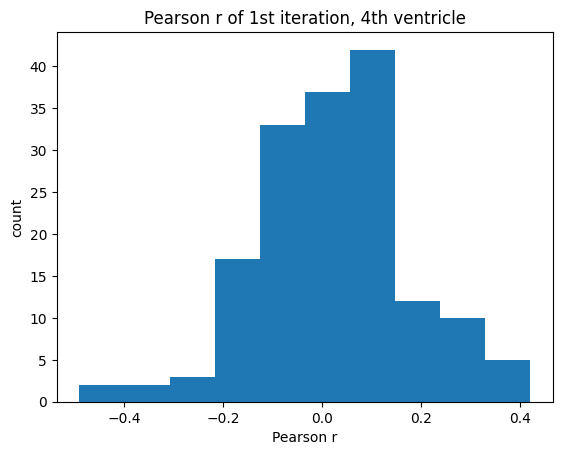

In [63]:
plt.hist(v4_gm_correlations)
plt.title('Pearson r of 1st iteration, 4th ventricle')
plt.xlabel('Pearson r')
plt.ylabel("count")

Text(0, 0.5, 'count')

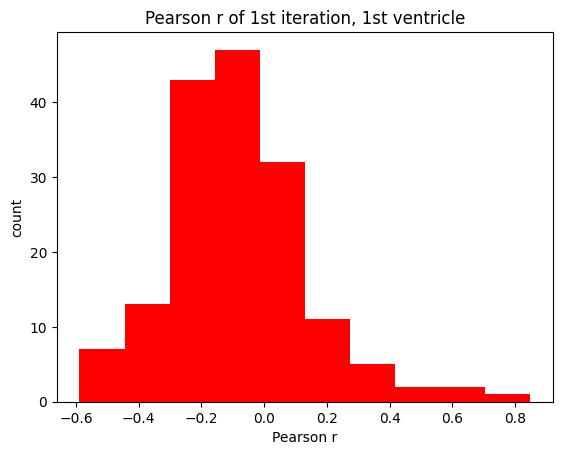

In [30]:
plt.hist(v1_gm_correlations,color='red')
plt.title('Pearson r of 1st iteration, 1st ventricle')
plt.xlabel('Pearson r')
plt.ylabel('count')

([<matplotlib.axis.XTick at 0x7f38bd573e10>,
 [Text(4.2315985272227053e-26, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9')])

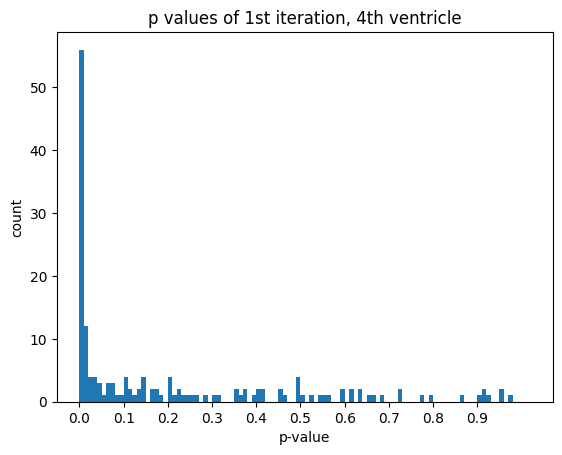

In [64]:
p4s_arr = np.array(p4s)
plt.hist(p4s_arr,bins=np.arange(p4s_arr.min(),p4s_arr.max()+0.05,0.01))
plt.title('p values of 1st iteration, 4th ventricle')
plt.xlabel('p-value')
plt.ylabel('count')
plt.xticks(np.arange(p4s_arr.min(),p4s_arr.max(),0.1))

In [65]:
sum(1 for p in p4s if p <= 0.05)

79

Text(0, 0.5, 'count')

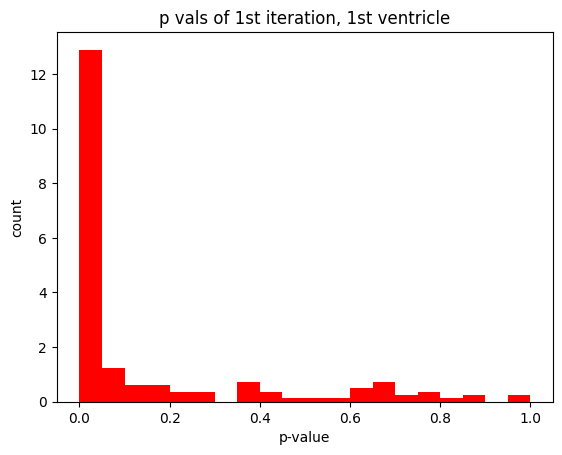

In [33]:
p1s_arr = np.array(p1s)
plt.hist(p1s,bins=np.arange(p1s_arr.min(),p1s_arr.max()+0.05,0.05),density=True,color='red')
plt.title('p vals of 1st iteration, 1st ventricle')
plt.xlabel('p-value')
plt.ylabel('count')

Text(0, 0.5, 'count')

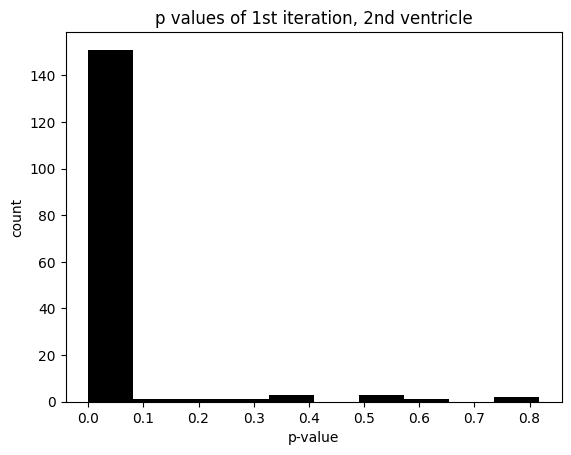

In [36]:
p2s_arr = np.array(p2s)
plt.hist(p2s_arr,color='black')
plt.title('p values of 1st iteration, 2nd ventricle')
plt.xlabel('p-value')
plt.ylabel('count')

In [66]:
sorted_v4_ps = np.sort(p4s_arr)
sorted_v4_corr = np.sort(v4_gm_correlations)
print(sorted_v4_corr[0:30])
sorted_v1_corr = np.sort(v1_gm_correlations)
print(sorted_v1_corr[0:30])

[-0.48957119 -0.47311284 -0.33843919 -0.33301643 -0.25669526 -0.24003365
 -0.23877159 -0.20993283 -0.20942088 -0.20710485 -0.20609442 -0.20181613
 -0.17861716 -0.15691338 -0.15609522 -0.15172917 -0.14495412 -0.13679464
 -0.13535549 -0.13223095 -0.13125691 -0.13063084 -0.12839015 -0.12601103
 -0.12447394 -0.11891179 -0.11048112 -0.11037538 -0.10417053 -0.10212868]
[-0.58857399 -0.5590387  -0.54212286 -0.51098744 -0.48054078 -0.46259267
 -0.46084424 -0.44098791 -0.43760201 -0.42419561 -0.40472768 -0.39370369
 -0.39274111 -0.38404143 -0.37877082 -0.37825559 -0.35590683 -0.33032771
 -0.31771011 -0.31664607 -0.28027034 -0.27449205 -0.27371404 -0.27232367
 -0.26958628 -0.25894868 -0.25685168 -0.25144022 -0.24622001 -0.24376121]


From visual inspection it is clear that the subjects with the highest csf to gm signal correlation values have their csf roi spherical centroids in a position that for them leads to non-csf signal being extracted. To correct for this, the position of the centroid will be adjusted 8mm in the posterior direction and 6mm in the superior direction

In [67]:
unaligned_4thvent_list = open('/media/corey/4TB-WDBlue/data-thesis/unaligned.txt')
sublist_u = unaligned_4thvent_list.readlines()

In [68]:
v4_gm_correlations_u = []
p4s_u = []
swsc4_u = []

for n, sub in enumerate(sublist_u):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()

    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent4_sphere = epi_data[45:46,40:41,38:39,:] #4th ventricle
    avg_vent4 = []
    for t in range(0,vent4_sphere.shape[3]):    
        v4_avg = np.mean(vent4_sphere[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    v4_gm_correlations_u.append(sp_corr4)
    p4s_u.append(p4)
    if p4 <= 0.05:
        swsc4_u.append(sub)


Text(0, 0.5, 'count')

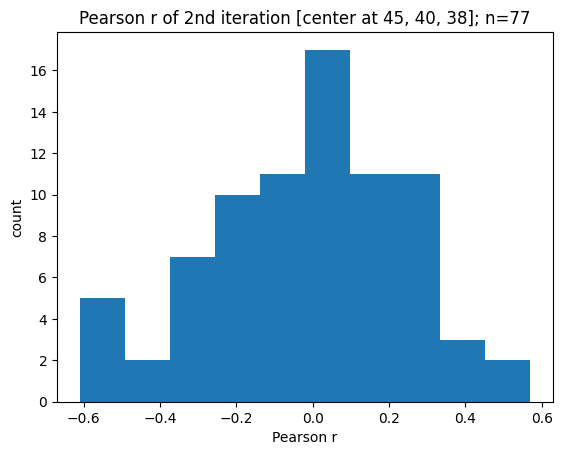

In [69]:
plt.hist(v4_gm_correlations_u)
plt.title('Pearson r of 2nd iteration [center at 45, 40, 38]; n=77')
plt.xlabel('Pearson r')
plt.ylabel('count')

Text(0, 0.5, 'count')

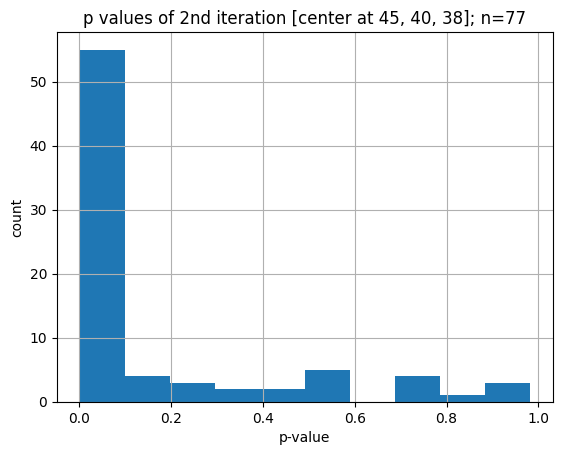

In [70]:
plt.grid()
plt.hist(p4s_u)
plt.title('p values of 2nd iteration [center at 45, 40, 38]; n=77')
plt.xlabel('p-value')
plt.ylabel('count')


In [72]:
print(len(swsc4_u))

53


In [ ]:
with open('/media/corey/4TB-WDBlue/data-thesis/unaligned_v4_2.txt','w+') as file:
    for su in swsc4_u:
        file.write('%s\n' %su)
file.close

In [75]:
unaligned_3its = open('/media/corey/4TB-WDBlue/data-thesis/unaligned_v4_2.txt')
sublist_3it = unaligned_3its.readlines()

In [76]:
print(len(sublist_3it))

53


In [77]:
#New center at 45, 44, 37
csfgm_r = []
p_3its = []
sws_3its = []

for n, sub in enumerate(sublist_3it):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()

    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent4_sphere = epi_data[45:46,43:44,36:37,:] #4th ventricle
    avg_vent4 = []
    for t in range(0,vent4_sphere.shape[3]):    
        v4_avg = np.mean(vent4_sphere[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    csfgm_r.append(sp_corr4)
    p_3its.append(p4)
    if p4 <= 0.05:
        sws_3its.append(sub)

Text(0.5, 1.0, 'Pearson r of 3rd iteration [center at 45, 44, 37]; n=51')

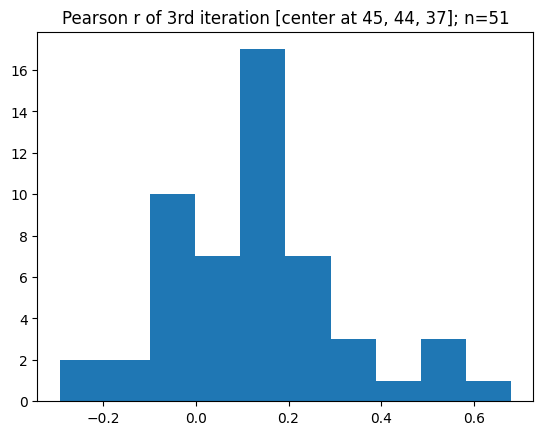

In [78]:
plt.hist(csfgm_r)
plt.title('Pearson r of 3rd iteration [center at 45, 44, 37]; n=51')

Text(0, 0.5, 'count')

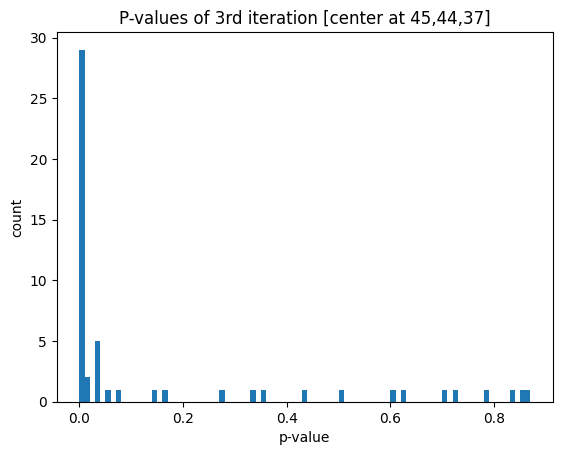

In [81]:
p_3_arr = np.array(p_3its)
plt.hist(p_3its,bins=np.arange(p_3_arr.min(),p_3_arr.max()+0.01,0.01))
plt.title('P-values of 3rd iteration [center at 45,44,37]')
plt.xlabel('p-value')
plt.ylabel('count')

In [82]:
print(sws_3its)

['1005', '1013', '1021', '1033', '1037', '1040', '1052', '1053', '1067', '1074', '1078', '1086', '1087', '1088', '1094', '1104', '2006', '2019', '2028', '2040', '2046', '3001', '3011', '3025', '3026', '3031', '3040', '4005', '4010', '4014', '4018', '4023', '4059', '4066', '4072', '4074']


In [ ]:
with open('/media/corey/4TB-WDBlue/data-thesis/unaligned_v4_3.txt','w+') as file:
    for su in sws_3its:
        file.write('%s\n' %su)
file.close

In [84]:
unaligned_3its = open('/media/corey/4TB-WDBlue/data-thesis/unaligned_v4_3.txt')
sublist_3it = unaligned_3its.readlines()
print(len(sublist_3it))

36


In [90]:
#New center at 45, 43, 22
csfgm_r4 = []
p_4its = []
sws_4its = []

for n, sub in enumerate(sublist_3it):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()

    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent4_sphere = epi_data[44:45,42:43,21:22,:] #4th ventricle
    avg_vent4 = []
    for t in range(0,vent4_sphere.shape[3]):    
        v4_avg = np.mean(vent4_sphere[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    csfgm_r4.append(sp_corr4)
    p_4its.append(p4)
    if p4 <= 0.05:
        sws_4its.append(sub)

In [89]:
print(len(sws_4its))
print(sws_4its)

26
['1013', '1021', '1033', '1037', '1040', '1052', '1053', '1067', '1086', '1088', '1094', '1104', '2006', '2019', '2028', '3001', '3011', '3025', '3031', '3040', '4005', '4010', '4014', '4023', '4066', '4072']


Text(0, 0.5, 'count')

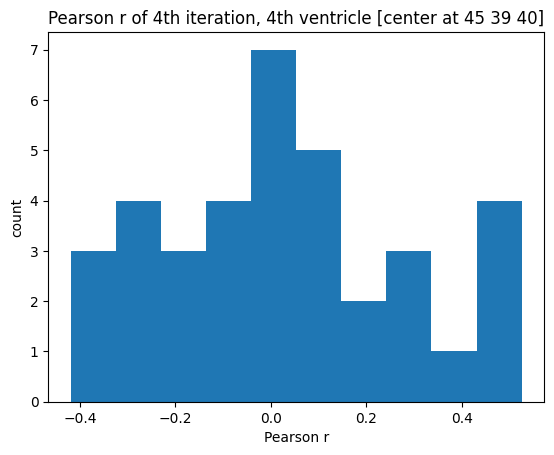

In [87]:
plt.hist(csfgm_r4)
plt.title('Pearson r of 4th iteration, 4th ventricle [center at 45 39 40]')
plt.xlabel('Pearson r')
plt.ylabel('count')

Text(0, 0.5, 'count')

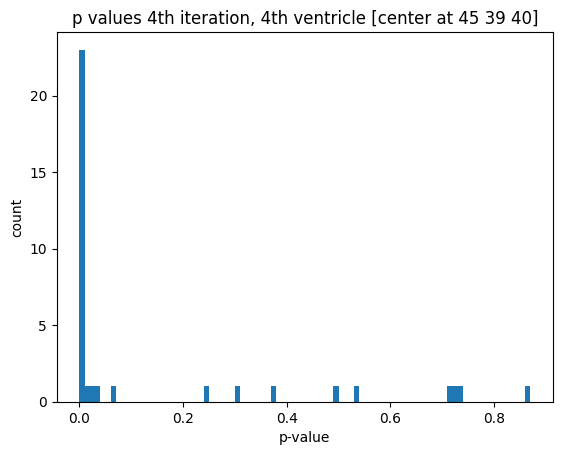

In [88]:
p_4_arr = np.array(p_4its)
plt.hist(p_4its,bins=np.arange(p_4_arr.min(),p_4_arr.max()+0.01,0.01))
plt.title('p values 4th iteration, 4th ventricle [center at 45 39 40]')
plt.xlabel('p-value')
plt.ylabel('count')

In [1]:
import nibabel as nib
import numpy as np
import scipy.stats as stats

In [2]:
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

In [ ]:
#New center at 45, 44, 37
opt_r = []
opt_p = []
opt_swsc = []
cerebellar_mask = nib.load('/usr/local/fsl/data/atlases/Cerebellum/Cerebellum-MNIflirt-maxprob-thr0-2mm.nii.gz')
cerb_data = cerebellar_mask.get_fdata()
for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    gmdata = gm_signal.get_fdata()
    avgd_gm = []
    avg_vent4 = []
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    wm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_wm_mask.nii.gz' %sub)
    gm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_gm_mask.nii.gz' %sub)
    wm_data = wm_mask.get_fdata()
    gm_mask_data = gm_mask.get_fdata()
    vent4_sphere = epi_data[41:49,41:49,31:39,:] #4th ventricle
    avg_v4_sphere = np.mean(vent4_sphere,axis=3)
    vent4_min = np.unravel_index(np.argmin(avg_v4_sphere,axis=None),shape=avg_v4_sphere.shape)
    new_center = vent4_min
    offsets = [41 + new_center[0], 41 + new_center[1], 31 + new_center[2]]
    new_sphere = epi_data[offsets[0]-1:offsets[0]+1,offsets[1]-1:offsets[1]+1,offsets[2]-1:offsets[2]+1,:]
    
    for x in range(0,new_sphere.shape[0]):
        for y in range(0,new_sphere.shape[1]):
            for z in range(0,new_sphere.shape[2]):
                if wm_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0 or cerb_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0 or gm_mask_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0:
                    new_sphere[x,y,z,:] = 0
    new_sphere[new_sphere > 6000] = 0
    for t in range(0,gmdata.shape[3]):
        avg_gm = np.true_divide(gmdata[:,:,:,t].sum(1),(gmdata[:,:,:,t]!=0).sum(1))
        mean_gm_signal = np.nanmean(avg_gm)
        avgd_gm.append(mean_gm_signal)
        avg_csf = np.true_divide(new_sphere[:,:,:,t].sum(1),(new_sphere[:,:,:,t]!=0).sum(1))
        mean_signal_v4 = np.nanmean(avg_csf)
        avg_vent4.append(mean_signal_v4)

    v4 = np.array(avg_vent4)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    opt_r.append(sp_corr4)
    opt_p.append(p4)
    if p4 <= 0.05:
        opt_swsc.append(sub)
        print(n,sub,'significant correlation of csf to gm', offsets, sp_corr4)
    else:
        print(n,sub, offsets, sp_corr4)

In [ ]:
print(len(opt_swsc))
print(opt_swsc)

In [11]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(opt_r)
plt.title('Pearson r of 4th ventricle csf and global grey matter')

In [ ]:
plt.hist(opt_p)

In [ ]:
v4_gm_correlations_m = []
p4s_m = []
swsc4_m = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    gm_signal = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR' %sub):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2'):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        #num_nz = np.count_nonzero(data[:,:,:,t])
        #sum_gmSig = np.sum(data[:,:,:,t])
        avg = np.mean(data[:,:,:,t])
        avgd_gm.append(avg)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA' %sub):
        filename = str('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    #vent4_sphere = epi_data[45:46,40:41,38:39,:] #4th ventricle
    for x in range(0,mask4_data.shape[0]-1): #Loop method
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    
    #d4_mask = np.empty_like(epi_data)
    #for t in range(0,epi_data.shape[3]-1):
    #    d4_mask[:,:,:,t] = mask4_data
    #vent_4 = epi_data * d4_mask
    avg_vent4 = []

    for t in range(0,vent_4.shape[3]):
        num_nzv4 = np.count_nonzero(vent_4[:,:,:,t])
        sum_v4 = np.sum(vent_4[:,:,:,t])
        v4_avg = sum_v4 / num_nzv4 #np.mean(vent_4[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    np.savetxt('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/Average_4thVent_raw.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    v4_gm_correlations_m.append(sp_corr4)
    p4s_m.append(p4)
    if p4 <= 0.05:
        swsc4_m.append(sub)
        print(sub, 'p<=0.05')

Text(0.5, 1.0, 'Pearson r of 4th ventricle csf and global grey matter [mask generated]')

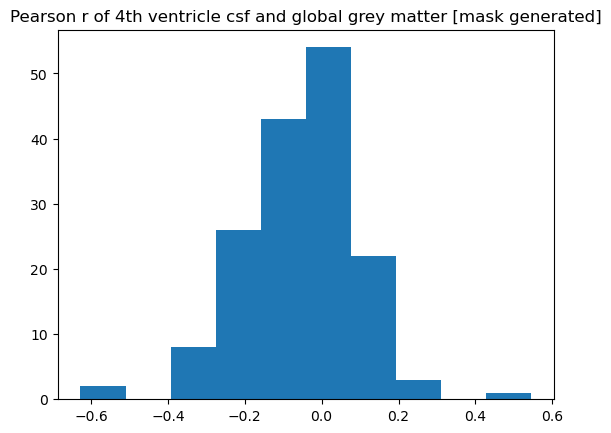

In [7]:
import matplotlib.pyplot as plt
plt.hist(v4_gm_correlations_m)
plt.title('Pearson r of 4th ventricle csf and global grey matter [mask generated]')

In [8]:
print(len(swsc4_m))

68


Text(0.5, 1.0, 'p-values 4th ventricle csf and global grey matter [mask generated]')

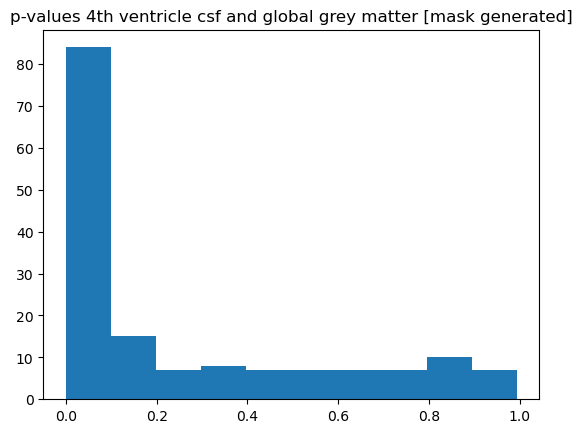

In [9]:
plt.hist(p4s_m)
plt.title('p-values 4th ventricle csf and global grey matter [mask generated]')

In [3]:
import glob

In [ ]:
v4_gm_correlations_nlfo = []
p4s_nlfo = []
swsc4_nlfo = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR' %sub):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2'):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = glob.glob('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/Rap*_%s_PA_desc-lfofilterCleaned_bold.nii.gz' % (sub, sub))[0]
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    for x in range(0,mask4_data.shape[0]-1):
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    avg_vent4 = []
    for t in range(0,vent_4.shape[3]):    
        num_nzv4 = np.count_nonzero(vent_4[:,:,:,t])
        sum_v4sig = np.sum(vent_4[:,:,:,t])
        v4_avg = sum_v4sig / num_nzv4 
        avg_vent4.append(v4_avg)
    v4 = np.array(avg_vent4)
    np.savetxt(f'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/averaged_4thVent_nlfo.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    v4_gm_correlations_nlfo.append(sp_corr4)
    p4s_nlfo.append(p4)
    if p4 <= 0.05:
        swsc4_nlfo.append(sub)
        print(sub, p4)


In [10]:
print(len(swsc4_nlfo))

63


Text(0.5, 1.0, 'Pearson r of 4th ventricle csf and global grey matter')

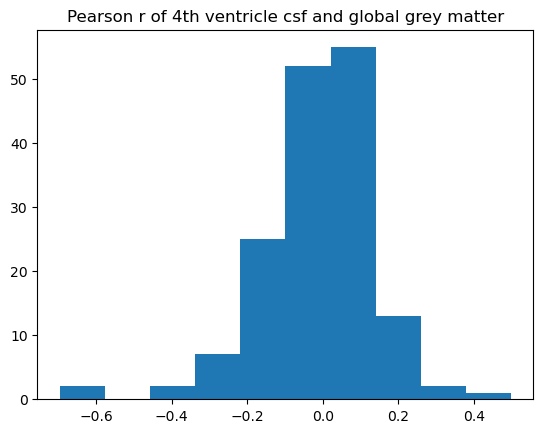

In [13]:
import matplotlib.pyplot as plt
plt.hist(v4_gm_correlations_nlfo)
plt.title('Pearson r of 4th ventricle csf and global grey matter')

Text(0.5, 1.0, 'p-values 4th ventricle csf and global grey matter')

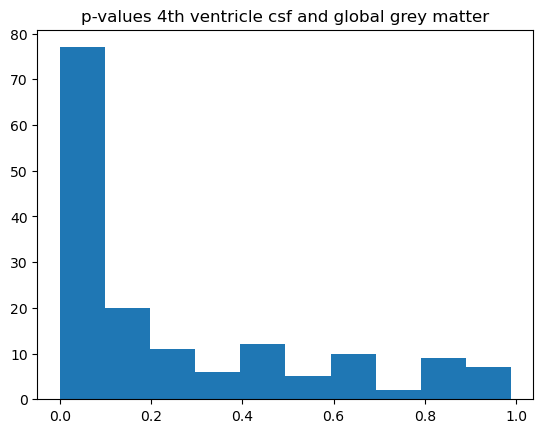

In [18]:
plt.hist(p4s_nlfo)
plt.title('p-values 4th ventricle csf and global grey matter')

In [18]:
print(swsc4_nlfo)

['1004', '1018', '1020', '1028', '1043', '1053', '1056', '1060', '1061', '1065', '1067', '1076', '1077', '1079', '1082', '1087', '2001', '2004', '2006', '2023', '2041', '2042', '2048', '2049', '3002', '3026', '3031', '4010', '4011', '4014', '4027', '4057', '4058', '4065']


In [20]:
#Resample csf mask generated by spm
MNI152_2mm = nib.load('/usr/local/fsl/data/atlases/MNI/MNI-maxprob-thr0-2mm.nii.gz')

for n, sub in enumerate(sublist):
    sub = sub.strip()
    #filename = '/media/corey/2_4TB-WDBlue/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/c3T2w_restore.nii' %sub
    #csf_mask = nib.load(filename)
    wm_file = '/media/corey/2_4TB-WDBlue/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/c2T2w_restore.nii' %sub
    wm_mask = nib.load(wm_file)
    #resampled2mm_csf = prc.resample_from_to(csf_mask,MNI152_2mm,order=0)
    resampled2mm_wm = prc.resample_from_to(wm_mask,MNI152_2mm,order=0)
    #nib.save(resampled2mm_csf,'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/resampled2mm_csf.nii.gz' %sub)
    nib.save(resampled2mm_wm,'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/resampled2mm_wm.nii.gz' %sub)



In [ ]:
wm_gm_nlfo = []
p_wm_nlfo = []
s_wm_nlfo = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    
    maskwm = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/resampled2mm_wm.nii.gz' %sub)
    maskwm_data = maskwm.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = glob.glob('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/Rap*_%s_PA_desc-lfofilterCleaned_bold.nii.gz' % (sub, sub))[0]
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    white_matter = np.zeros_like(epi_data)
    for x in range(0,maskwm_data.shape[0]-1): #Loop method
        for y in range(0,maskwm_data.shape[1]-1):
            for z in range(0,maskwm_data.shape[2]-1):
                if maskwm_data[x,y,z] >= 0.95:
                    for t in range(0,epi_data.shape[3]):
                        white_matter[x,y,z,t] = epi_data[x,y,z,t]
    avg_wm = []
    for t in range(0,vent_4.shape[3]):    
        wm_avg = np.mean(white_matter[:,:,:,t])
        avg_wm.append(wm_avg)

    wm_arr = np.array(avg_wm)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(wm_arr,gm)
    wm_gm_nlfo.append(sp_corr4)
    p_wm_nlfo.append(p4)
    if p4 <= 0.05:
        s_wm_nlfo.append(sub)
        print(sub, p4)

In [36]:
np.savetxt('/home/corey/Desktop/wm_arr_test.txt',wm_arr,fmt='%10.5f')

In [24]:
print(len(s_wm_nlfo))

38


In [ ]:
plt.hist(wm_gm_nlfo)
plt.title('Pearson r of global csf and global white matter')

Text(0.5, 1.0, 'p-values 4th ventricle csf and global grey matter')

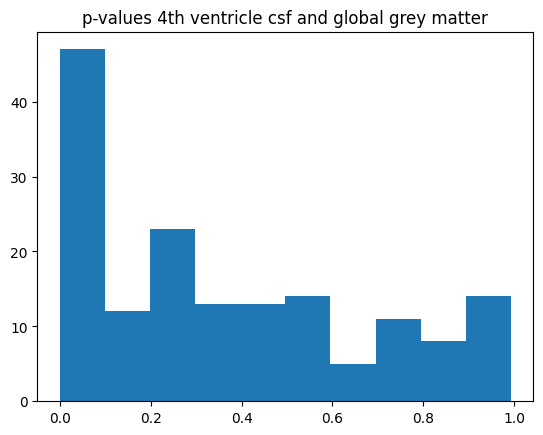

In [26]:
plt.hist(p_wm_nlfo)
plt.title('p-values 4th ventricle csf and global grey matter')

In [ ]:
def common_member(a,b):
    result = [i for i in a if i in b]
    return result
a = s_nlfo
b = s_wm_nlfo
common_list = common_member(a,b)
print(common_list)
print(len(common_list))

In [ ]:
r_sm_nlfo = []
p_sm_nlfo = []
s_sm_nlfo = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/6mm_gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR' %sub):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2'):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/smoothedRT_FWHM6mm.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    for x in range(0,mask4_data.shape[0]-1): #Loop method
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    avg_vent4 = []
    for t in range(0,vent_4.shape[3]):    
        num_nzv4 = np.count_nonzero(vent_4[:,:,:,t])
        sum_v4sig = np.sum(vent_4[:,:,:,t])
        v4_avg = sum_v4sig / num_nzv4 #np.mean(vent_4[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    np.savetxt(f'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/averaged_4thVent_6mmFWHM.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    r_sm_nlfo.append(sp_corr4)
    p_sm_nlfo.append(p4)
    if p4 <= 0.05:
        s_sm_nlfo.append(sub)
        print(sub, p4)

Text(0.5, 1.0, 'Pearson r of 4th ventricle csf and global grey matter [smoothed & lfo corrected]')

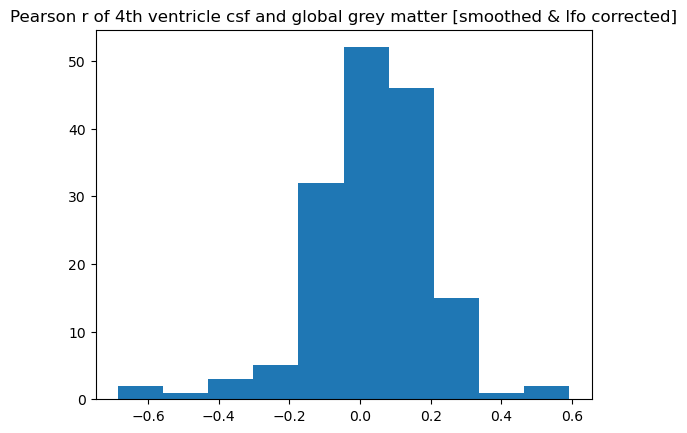

In [33]:
plt.hist(r_sm_nlfo)
plt.title('Pearson r of 4th ventricle csf and global grey matter [smoothed & lfo corrected]')

In [34]:
print(len(s_sm_nlfo))

86


Text(0.5, 1.0, 'p-values correlation 4th ventricle csf and global grey matter [mask generated]')

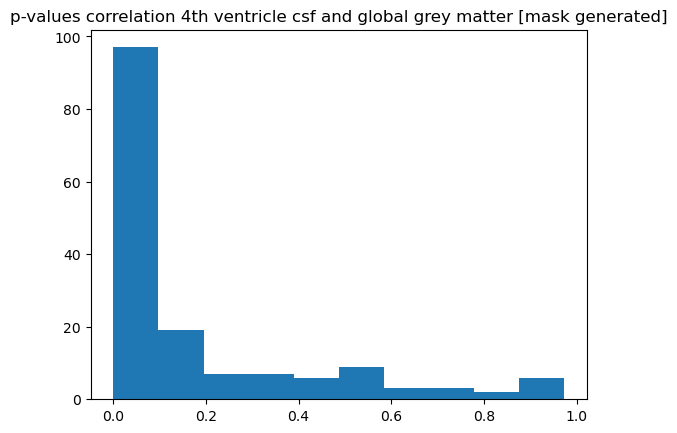

In [36]:
plt.hist(p_sm_nlfo)
plt.title('p-values correlation 4th ventricle csf and global grey matter [mask generated]')

Perhaps the signals from the lateral ventricles will be more promising with respect to the low-frequency oscillation corrected and subsequently smoothed data

In [1]:
import nibabel as nib
import numpy as np
import os

In [3]:
#Load csf masks
#csf_mask = nib.load('/media/corey/2_4TB-WDBlue/ext_data/EP_FunctionalPreprocessing/1001_01_MR/MNINonLinear/c3T2w_restore.nii')
csf_mask = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/1001_01_MR/PA/masks/resampled2mm_csf.nii.gz')
csf_mask_data = csf_mask.get_fdata()
print(csf_mask_data.shape)

(91, 109, 91)


In [ ]:
print(csf_mask_data[40:50,57:67,40:45])

In [9]:
affine = csf_mask.affine
new_mask_data = np.zeros_like(csf_mask_data)
for x in range(29,59):
    for y in range(40,76):
        for z in range(34,49):
            if csf_mask_data[x,y,z] >= 0.9:
                new_mask_data[x,y,z] = 1
for x in range(41,46):
    for y in range(44,54):
        for z in range(34,44):
            new_mask_data[x,y,z] = 0
new_mask = nib.Nifti1Image(new_mask_data,affine)
nib.save(new_mask,'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/1001_01_MR/PA/masks/1st&2ndVent_test.nii.gz')

In [11]:
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

In [ ]:
for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    csf_mask = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/resampled2mm_csf.nii.gz' %sub)
    csf_mask_data = csf_mask.get_fdata()
    affine = csf_mask.affine
    new_mask_data = np.zeros_like(csf_mask_data)
    for x in range(29,59):
        for y in range(46,76):
            for z in range(34,49):
                if csf_mask_data[x,y,z] >= 0.9:
                    new_mask_data[x,y,z] = 1
    for x in range(41,46):
        for y in range(44,54):
            for z in range(34,44):
                new_mask_data[x,y,z] = 0
    new_mask = nib.Nifti1Image(new_mask_data,affine)
    nib.save(new_mask,'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/1st&2ndVent_test.nii.gz' %sub)

In [16]:
import glob
import scipy.stats as stats

In [ ]:
r1_nlfo = []
p1_nlfo = []
s1_nlfo = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    mask4 = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/1st&2ndVent_test.nii.gz' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = glob.glob('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/Rap*_%s_PA_desc-lfofilterCleaned_bold.nii.gz' % (sub, sub))[0]
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    for x in range(0,mask4_data.shape[0]-1): #Loop method
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    avg_vent4 = []
    for t in range(0,vent_4.shape[3]):    
        v4_avg = np.mean(vent_4[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    np.savetxt('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/average_1st&2ndVent_test.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    r1_nlfo.append(sp_corr4)
    p1_nlfo.append(p4)
    if p4 <= 0.05:
        s1_nlfo.append(sub)
        print(sub, p4)

In [19]:
print(len(s1_nlfo))

124


(array([ 3.,  8., 12., 33., 41., 26., 17., 10.,  6.,  3.]),
 array([-0.4547985 , -0.31742424, -0.18004998, -0.04267572,  0.09469854,
         0.2320728 ,  0.36944706,  0.50682132,  0.64419558,  0.78156983,
         0.91894409]),
 <BarContainer object of 10 artists>)

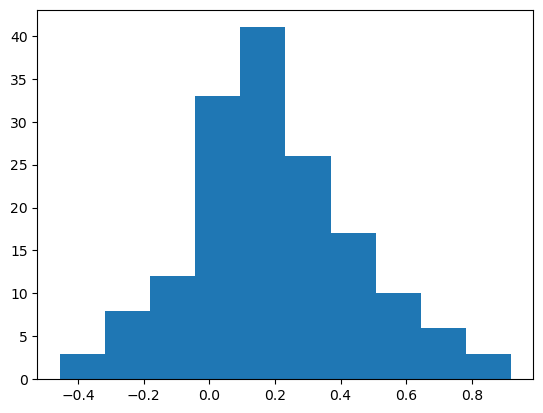

In [21]:
import matplotlib.pyplot as plt
plt.hist(r1_nlfo)

Assess correlation of 4th ventricle and grey matter from slow 4 and slow 5 frequency band data

In [22]:
import nibabel as nib
import numpy as np
import scipy.stats as stats

In [33]:
#import subject list up to sub 1060
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

In [ ]:
#Define frequency band 1 grey matter signal with fsl

In [34]:
r_f1 = []
p_f1 = []
s_f1 = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI_filtered/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR' %sub):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2'):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI_filtered/Filtered_4DVolume.nii' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    for x in range(0,mask4_data.shape[0]-1): #Loop method
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    avg_vent4 = []
    for t in range(0,vent_4.shape[3]):    
        num_nzv4 = np.count_nonzero(vent_4[:,:,:,t])
        sum_v4sig = np.sum(vent_4[:,:,:,t])
        v4_avg = sum_v4sig / num_nzv4 #np.mean(vent_4[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    np.savetxt('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/f1_4thVent_csf_mean.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    r_f1.append(sp_corr4)
    p_f1.append(p4)
    if p4 <= 0.05:
        s_f1.append(sub)
        print(sub, p4)

1001
1001 0.0052626265501891974
1002
1003
1004
1004 8.716030334676282e-11
1005
1005 0.007331244457350884
1006
1009
1010
1010 0.01583197269138371
1012
1013
1015
1017
1017 0.0018959355008281277
1018
1020
1021
1022
1024
1025
1025 0.0012869092997076122
1026
1027
1028
1029
1031
1031 0.010148888284576002
1032
1032 1.4938014402010383e-06
1033
1033 0.013907083399458292
1034
1034 0.0026165694519942723
1035
1036
1037
1038
1038 0.0006783907863730205
1039
1039 0.00044998226051066564
1040
1040 0.00017926246876803168
1041
1041 0.03818196785522074
1043
1043 3.5841665807289556e-11
1044
1044 0.00016651464862048557
1045
1047
1048
1051
1052
1053
1053 1.6548093011585536e-17
1056
1056 0.016803879510689686
1057
1057 0.030625602702903255
1060
1060 1.8435386283221233e-61
1061
1063
1063 0.00012056023486751468
1065
1065 0.017205900157359996
1067
1068
1068 0.017883366103971097
1069
1070
1070 0.03646437686397865
1072
1074
1075
1076
1076 6.470763476632381e-06
1077
1078
1078 0.01928657945784369
1079
1080
1081
1081 

Text(0, 0.5, 'count')

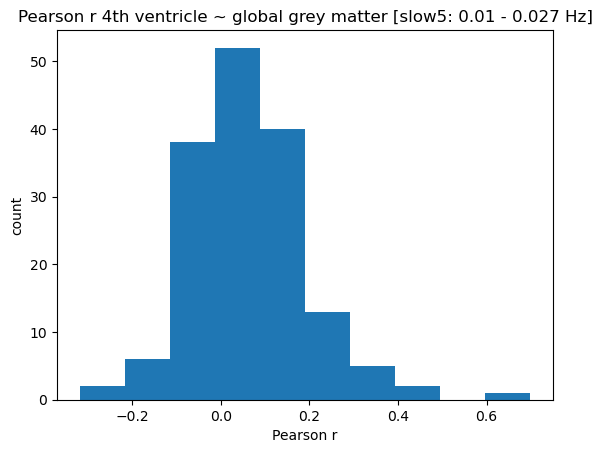

In [35]:
import matplotlib.pyplot as plt
#Plot histograms
plt.hist(r_f1)
plt.title('Pearson r 4th ventricle ~ global grey matter [slow5: 0.01 - 0.027 Hz]')
plt.xlabel('Pearson r')
plt.ylabel('count')

In [36]:
print(len(s_f1))

71


In [40]:
r_f2 = []
p_f2 = []
s_f2 = []

for n, sub in enumerate(sublist):
    sub = sub.strip()
    print(sub)
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI_f2_filtered/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR' %sub):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    if os.path.exists('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2'):
        mask4 = nib.load('/home/corey/Downloads/data/fourth_ventricle_mask_resliced2mm/%s_01_MR_REST2/Resliced_2mm_fourth_ventricle_mask.nii' %sub)
    mask4_data = mask4.get_fdata()
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
    filename = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI_f2_filtered/Filtered_4DVolume.nii' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent_4 = np.zeros_like(epi_data)
    for x in range(0,mask4_data.shape[0]-1): #Loop method
        for y in range(0,mask4_data.shape[1]-1):
            for z in range(0,mask4_data.shape[2]-1):
                if mask4_data[x,y,z] == 1:
                    for t in range(0,epi_data.shape[3]):
                        vent_4[x,y,z,t] = epi_data[x,y,z,t]
    avg_vent4 = []
    for t in range(0,vent_4.shape[3]):    
        num_nzv4 = np.count_nonzero(vent_4[:,:,:,t])
        sum_v4sig = np.sum(vent_4[:,:,:,t])
        v4_avg = sum_v4sig / num_nzv4 #np.mean(vent_4[:,:,:,t])
        avg_vent4.append(v4_avg)

    v4 = np.array(avg_vent4)
    np.savetxt('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/extracted_rois/f2_4thVent_csf_mean.txt' %sub,v4,fmt='%10.6f')
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    r_f2.append(sp_corr4)
    p_f2.append(p4)
    if p4 <= 0.05:
        s_f2.append(sub)
        print(sub, p4)

1001
1001 0.0009554680586635195
1002
1003
1004
1004 9.181564536333575e-12
1005
1005 0.01426521911442564
1006
1009
1010
1010 0.0009974309732371897
1012
1013
1015
1017
1017 9.154846901465152e-05
1018
1020
1021
1022
1024
1025
1025 0.000343046355126091
1026
1027
1028
1029
1031
1032
1032 0.005652964149370916
1033
1034
1034 0.000522466241870973
1035
1036
1037
1038
1038 0.0012383514554023417
1039
1039 0.00017126508550053244
1040
1040 9.464537057307107e-06
1041
1043
1043 2.096143950530663e-19
1044
1044 2.6176183527667145e-06
1045
1045 0.04592584647648306
1047
1048
1051
1052
1053
1053 1.9278940276646742e-17
1056
1057
1057 0.014287753760839628
1060
1060 4.274122530815088e-63
1061
1063
1063 0.0013009411229380138
1065
1067
1068
1069
1070
1070 0.02034659833512277
1072
1074
1074 0.021041226235653823
1075
1076
1076 1.816091846737465e-06
1077
1078
1079
1080
1081
1081 0.00022439333391513386
1082
1083
1084
1085
1085 0.006150794647894776
1086
1086 4.515411438487563e-25
1087
1087 0.0020731682702183163
108

Text(0, 0.5, 'count')

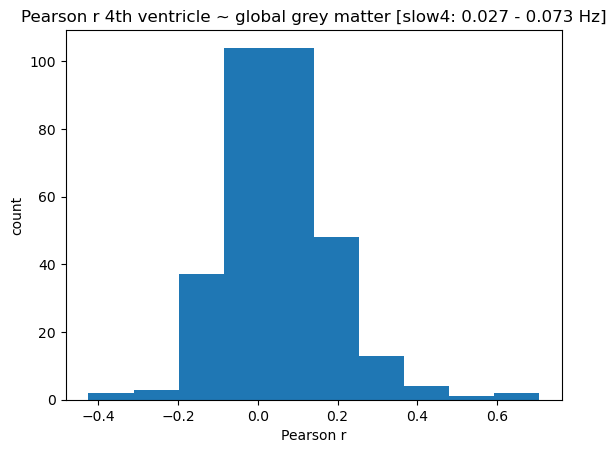

In [41]:
import matplotlib.pyplot as plt
#Plot histograms
plt.hist(r_f1)
plt.title('Pearson r 4th ventricle ~ global grey matter [slow4: 0.027 - 0.073 Hz]')
plt.xlabel('Pearson r')
plt.ylabel('count')

In [42]:
print(len(s_f2))

65
